In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import suncalc

import dask.dataframe as dd
from pathlib import Path
import glob
import re

import datetime as dt

import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches

In [2]:
import sys

sys.path.append("../src")
sys.path.append("../src/activity")

In [3]:
import subsampling as ss
import activity_assembly as actvt
import bout.assembly as bt
import comparison.data_assembly as comp
import comparison.plot as complot
from core import SITE_NAMES

from cli import get_file_paths
import plot
import pipeline

In [4]:
POINT_CMAP = {0:'w',1:'r',2:'b',3:'g',4:'orange',5:'c',6:'pink',7:'k'}
POINT_CMAP

{0: 'w', 1: 'r', 2: 'b', 3: 'g', 4: 'orange', 5: 'c', 6: 'pink', 7: 'k'}

In [5]:
avail = np.arange(0, 720, 6) + 6
reset_24 = avail[np.where((24*60 % avail) == 0)[0]]

cycle_lengths = [6, 18, 30, 60, 120, 180]
percent_ons = [1/6, 1/3, 1/2, 2/3]
data_params = dict()
data_params["cycle_lengths"] = cycle_lengths
data_params["percent_ons"] = percent_ons
data_params['index_time_block_in_secs'] = '5'
dc_tags = ss.get_list_of_dc_tags(data_params["cycle_lengths"], data_params["percent_ons"])

site_key = 'Carp'
type_keys = ['LF', 'HF']
data_params["dc_tags"] = dc_tags
data_params["site_tag"] = site_key
data_params['cur_dc_tag'] = '30of30'
data_params["site_name"] = SITE_NAMES[site_key]
data_params['metric_tag'] = 'call_rate'
data_params['recording_start'] = '00:00'
data_params['recording_end'] = '16:00'
data_params['start'] = dt.datetime(2022, 8, 10, 0, 0, 0)
data_params['end'] = dt.datetime(2022, 8, 16, 16, 0, 0)

# for type_key in type_keys:
type_key = 'LF'
print(site_key, type_key)
data_params["type_tag"] = type_key
file_paths = get_file_paths(data_params)
file_paths

Carp LF


{'raw_SITE_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../data/raw/Carp',
 'SITE_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../data/2022_bd2_summary/Carp',
 'SITE_classes_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../data/classifications/Carp',
 'SITE_classes_file': '/Users/adityakrishna/duty-cycle-investigation/src/../data/classifications/Carp/2022_Carp_call_classes.csv',
 'bd2_TYPE_SITE_YEAR': 'bd2__LFCarp_2022',
 'duty_cycled_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../data/2022_bd2_summary/Carp/duty_cycled',
 'dc_dets_TYPE_SITE_summary': 'dc_dets_LFCarp_summary',
 'dc_bouts_TYPE_SITE_summary': 'dc_bouts_LFCarp_summary',
 'dc_inds_TYPE_SITE_summary': 'dc_inds_LFCarp_summary',
 'dc_callrate_TYPE_SITE_summary': 'dc_callrate_LFCarp_summary',
 'cont_callrate_TYPE_SITE_summary': 'cont_callrate_LFCarp_summary',
 'dc_btp_TYPE_SITE_summary': 'dc_btp_LFCarp_summary',
 'cont_btp_TYPE_SITE_summary': 'cont_btp_LFCarp_summary',

In [6]:
activity_arr = pd.read_csv(f'{file_paths["duty_cycled_folder"]}/{file_paths["dc_callrate_TYPE_SITE_summary"]}.csv', index_col=0)
callrate_arr = pd.read_csv(f'{file_paths["duty_cycled_folder"]}/{file_paths["cont_callrate_TYPE_SITE_summary"]}.csv', index_col=0)
activity_arr.index = pd.DatetimeIndex(activity_arr.index)
callrate_arr.index = pd.DatetimeIndex(callrate_arr.index)
activity_arr

,call_rate (1of6),call_rate (2of6),call_rate (3of6),call_rate (4of6),call_rate (3of18),call_rate (6of18),call_rate (9of18),call_rate (12of18),call_rate (5of30),call_rate (10of30),...,call_rate (30of60),call_rate (40of60),call_rate (20of120),call_rate (40of120),call_rate (60of120),call_rate (80of120),call_rate (30of180),call_rate (60of180),call_rate (90of180),call_rate (120of180)
datetime_UTC,,,,,,,,,,,,,,,,,,,,,
2022-07-13 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.358333
2022-07-13 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.716667,0.9500,NaN,NaN,NaN,NaN
2022-07-13 04:48:00,NaN,NaN,NaN,NaN,NaN,0.166667,4.222222,3.583333,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-13 04:54:00,NaN,18.5,12.333333,10.5,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-13 05:00:00,NaN,0.0,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,3.3,...,1.266667,1.600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-17 09:18:00,NaN,NaN,0.666667,0.5,0.666667,0.333333,0.222222,0.166667,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-17 09:36:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-17 09:54:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
callrate_arr

,call_rate (6of6),call_rate (18of18),call_rate (30of30),call_rate (60of60),call_rate (120of120),call_rate (180of180)
datetime_UTC,,,,,,
2022-07-13 03:00:00,NaN,NaN,NaN,NaN,NaN,1.527778
2022-07-13 04:00:00,NaN,NaN,NaN,0.716667,2.291667,NaN
2022-07-13 04:30:00,NaN,NaN,1.433333,NaN,NaN,NaN
2022-07-13 04:48:00,0.166667,4.111111,NaN,NaN,NaN,NaN
2022-07-13 04:54:00,7.000000,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2022-10-17 09:54:00,0.000000,0.000000,NaN,NaN,NaN,NaN
2022-10-17 10:00:00,0.000000,NaN,0.033333,0.016667,0.008333,NaN
2022-10-17 10:06:00,0.000000,NaN,NaN,NaN,NaN,NaN


In [8]:
def plot_indiv_dc_control_comp_over_cycle_log_scale(single_col_dc_metr1, single_col_c_metr, data_params):
    dc_tag_split = re.findall(r"\d+", single_col_dc_metr1.columns[0])
    total = int(dc_tag_split[-1])
    on = int(dc_tag_split[0])
    listening_ratio = on/total
    single_col_dc_metr1.index = pd.DatetimeIndex(single_col_dc_metr1.index)
    dc_metr1 = pd.pivot_table(single_col_dc_metr1, index=(single_col_dc_metr1.index.time), 
                        columns=single_col_dc_metr1.index.date, 
                        values=single_col_dc_metr1.columns[0])
    dctag1 = re.search(r"\d+of\d+", single_col_dc_metr1.columns[0])[0]
    metrictag1 = (single_col_dc_metr1.columns[0]).split()[0]
    single_col_c_metr.index = pd.DatetimeIndex(single_col_c_metr.index)
    paired_col_c_metr = single_col_c_metr[(~single_col_dc_metr1.isna()).values]
    c_metr = pd.pivot_table(paired_col_c_metr, index=(paired_col_c_metr.index.time), 
                    columns=paired_col_c_metr.index.date, 
                    values=paired_col_c_metr.columns[0])
    plt.title(f'{dctag1} and continuous scheme')
    
    non_zero_c_metr_min = c_metr.replace(0, np.NaN).min().min()
    c_metr_max = c_metr.max().max()
    if data_params['metric_tag']=='activity_index':
        lower_bound = (100/(60/5))*(1/on)
        plt.axhline(y=lower_bound, linestyle='dashed', color='g', label='low: $on time^{-1}$')
    elif data_params['metric_tag']=='call_rate':
        lower_bound = (1/on)
        plt.axhline(y=lower_bound, linestyle='dashed', color='g', label='low: $on time^{-1}$')

    if data_params['metric_tag']=='bout_time_percentage':
        plt.axhline(y=100, linestyle='dashed', color='g', label='100% line')
    elif data_params['metric_tag']=='activity_index':
        plt.axhline(y=100, linestyle='dashed', color='g', label='100% line')

    bound_c_values = np.logspace(-3, 3, 3)
    plt.plot([non_zero_c_metr_min, c_metr_max], [non_zero_c_metr_min, c_metr_max], linestyle='dashed', color='k')
    plt.plot(bound_c_values, (1/listening_ratio)*bound_c_values, linestyle='dashed', color='g', label='upp: $ratio^{-1}$*c')
   
    colors = np.tile(np.arange(0, c_metr.shape[0]),(c_metr.shape[1],1)).T
    labels = pd.to_datetime(c_metr.index, format='%H:%M:%S').strftime('%H:%M')
    sc = plt.scatter(c_metr, dc_metr1, c=colors, cmap='YlOrRd', edgecolors='k', s=80, alpha=1)
    cbar = plt.colorbar(sc, ticks=[0, (colors.shape[0]-1)//2, colors.shape[0]-1])
    cbar.ax.set_yticklabels([labels[0], labels[len(labels)//2], labels[-1]])
    plt.xlabel(f'Continuous Measured {metrictag1}')
    plt.xscale('log')
    plt.yscale('log')
    if (data_params['metric_tag'] == 'call_rate'):
        plt.xlim(1e-4, 1e3)
        plt.ylim(1e-4, 1e3)
    else:
        plt.xlim(1e-3, 2e2)
        plt.ylim(1e-3, 2e2)
    plt.ylabel(f'DC Measured {metrictag1}')
    plt.grid(which='both')
    plt.legend(loc=3)

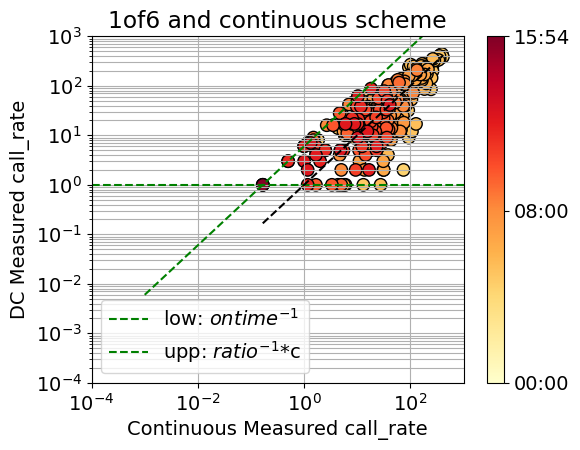

In [9]:
plt.figure(figsize=(6, 4.5))
plt.rcParams.update({'font.size':14})
prev_cycle = 0
dc_col = '1of6'
dc_metric_col_name = f'{data_params["metric_tag"]} ({dc_col})'
cycle_length = int(dc_col.split('of')[-1])
cont_tag = f'{cycle_length}of{cycle_length}'

cont_metric_col_name = f'{data_params["metric_tag"]} ({cont_tag})'
callrate_cont_column = pd.DataFrame(callrate_arr.loc[:,cont_metric_col_name].dropna())
metric_for_scheme = pd.DataFrame(activity_arr.loc[:,dc_metric_col_name].dropna())
metric_for_scheme_for_comparison = comp.get_associated_metric_for_cont_column(metric_for_scheme, callrate_cont_column)
plt_dcmetr, plt_cmetr = comp.select_dates_from_metrics(metric_for_scheme_for_comparison, callrate_cont_column, data_params)
plot_indiv_dc_control_comp_over_cycle_log_scale(plt_dcmetr, plt_cmetr, data_params)

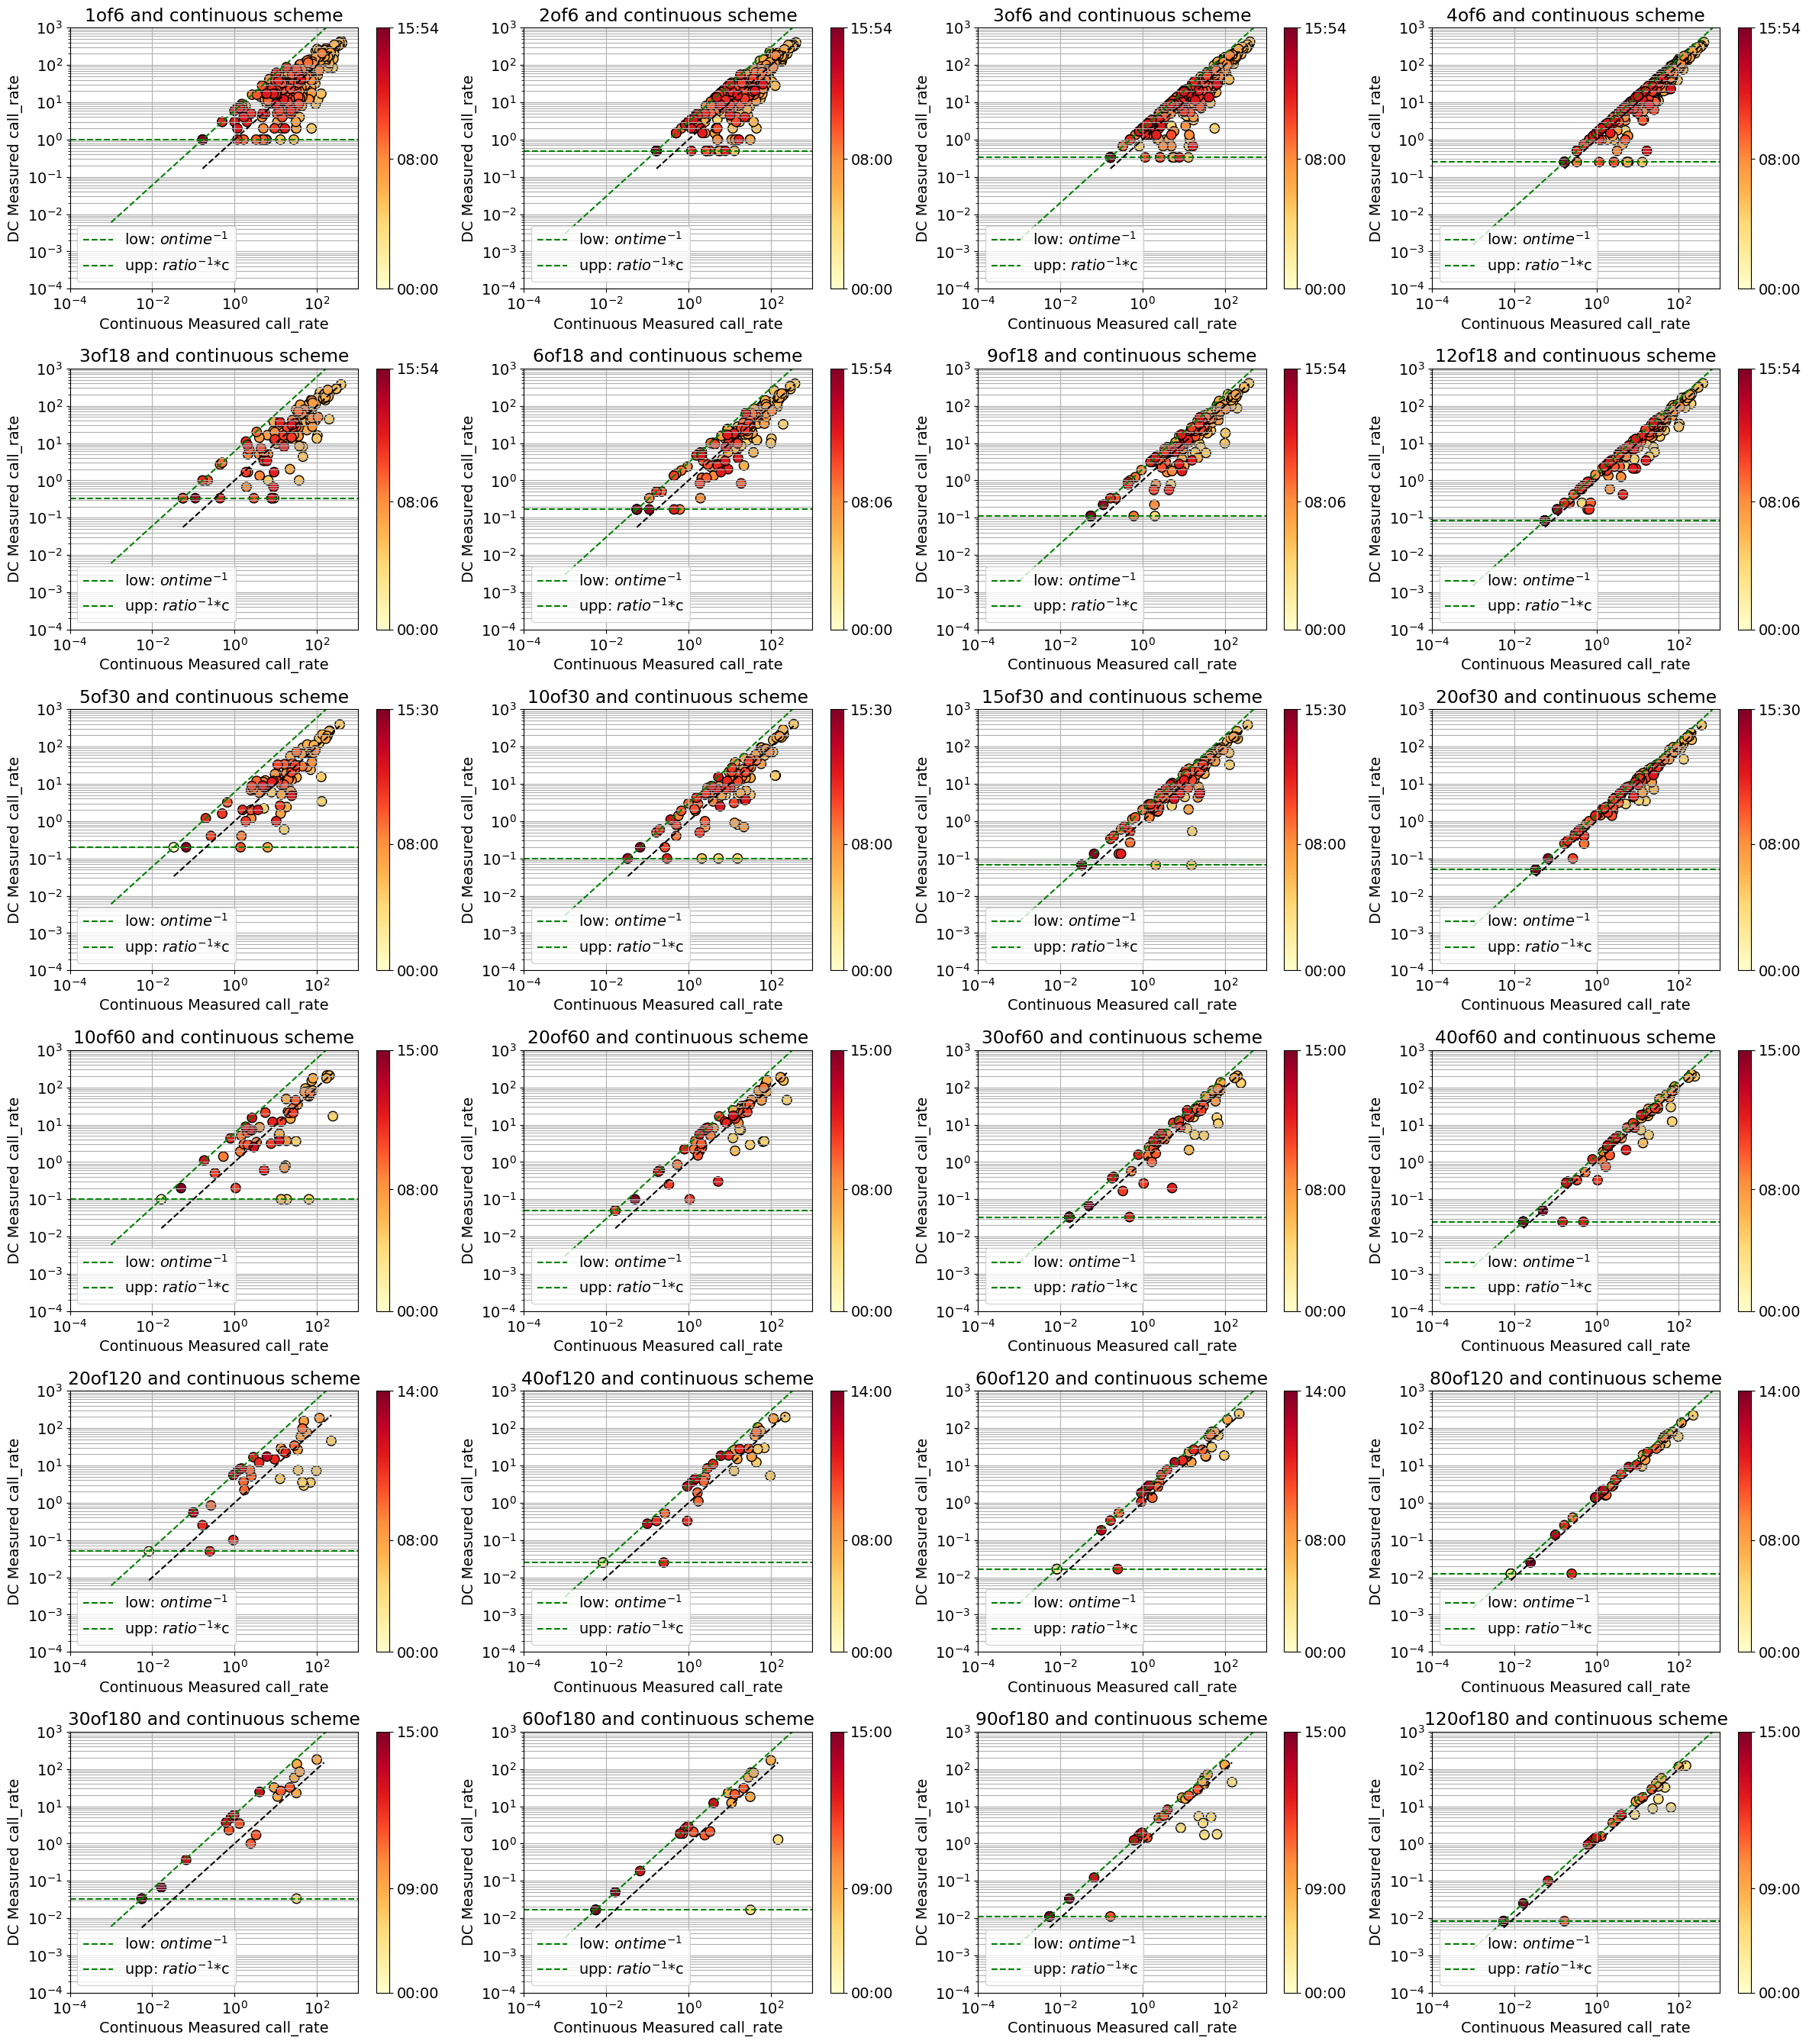

In [10]:
plt.figure(figsize=(6*len(data_params['percent_ons']), 4.5*len(data_params['cycle_lengths'])))
plt.rcParams.update({'font.size':14})
prev_cycle = 0
for i, dc_col in enumerate(data_params["dc_tags"][1:]):
    plt.subplot(len(data_params['cycle_lengths']), len(data_params['percent_ons']), i+1)
    metric_col_name = f'{data_params["metric_tag"]} ({dc_col})'
    cycle_length = int(dc_col.split('of')[-1])
    cont_tag = f'{cycle_length}of{cycle_length}'
    cont_metric_col_name = f'{data_params["metric_tag"]} ({cont_tag})'
    callrate_cont_column = pd.DataFrame(callrate_arr.loc[:,cont_metric_col_name].dropna())
    metric_for_scheme = pd.DataFrame(activity_arr.loc[:,metric_col_name].dropna())
    metric_for_scheme_for_comparison = comp.get_associated_metric_for_cont_column(metric_for_scheme, callrate_cont_column)
    plt_dcmetr, plt_cmetr = comp.select_dates_from_metrics(metric_for_scheme_for_comparison, callrate_cont_column, data_params)
    plot_indiv_dc_control_comp_over_cycle_log_scale(plt_dcmetr, plt_cmetr, data_params)

plt.tight_layout()
plt.show()

In [11]:
prev_cycle = 0
dc_col = '1of6'
dc_metric_col_name = f'{data_params["metric_tag"]} ({dc_col})'
cycle_length = int(dc_col.split('of')[-1])
time_on = int(dc_col.split('of')[0])
listening_ratio = time_on / cycle_length
cont_tag = f'{cycle_length}of{cycle_length}'

cont_metric_col_name = f'{data_params["metric_tag"]} ({cont_tag})'
callrate_cont_column = pd.DataFrame(callrate_arr.loc[:,cont_metric_col_name].dropna())
metric_for_scheme = pd.DataFrame(activity_arr.loc[:,dc_metric_col_name].dropna())
metric_for_scheme_for_comparison = comp.get_associated_metric_for_cont_column(metric_for_scheme, callrate_cont_column)
plt_dcmetr, plt_cmetr = comp.select_dates_from_metrics(metric_for_scheme_for_comparison, callrate_cont_column, data_params)

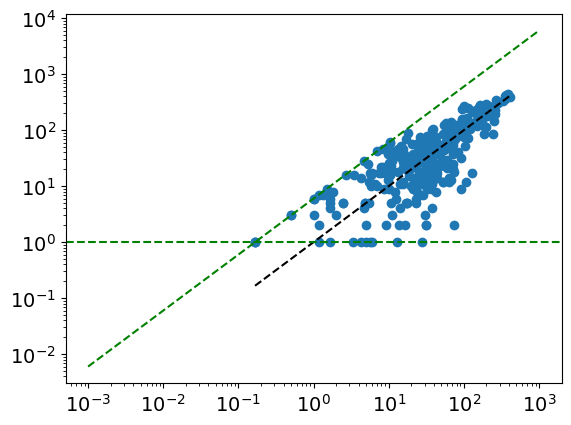

In [12]:
sorted_c_metr = plt_cmetr.sort_values(by='call_rate (6of6)').replace(0, np.NaN)
ref_dc_metr = plt_dcmetr.loc[sorted_c_metr.index]

bound_c_values = np.logspace(-3, 3, 3)
non_zero_c_metr_min = sorted_c_metr.min().min()
non_zero_dc_metr_min = ref_dc_metr.replace(0, np.NaN).min().min()
plt.plot([non_zero_c_metr_min, sorted_c_metr.max().max()], [non_zero_c_metr_min, sorted_c_metr.max().max()], linestyle='dashed', color='k')
plt.plot(bound_c_values, (1/listening_ratio)*bound_c_values, linestyle='dashed', color='g', label='upper: ratio*continuous')
plt.axhline(y=(non_zero_dc_metr_min/time_on), linestyle='dashed', color='g', label='lower: $on time^{-1}$')
plt.scatter(sorted_c_metr['call_rate (6of6)'], ref_dc_metr['call_rate (1of6)'])
plt.xscale('log')
plt.yscale('log')

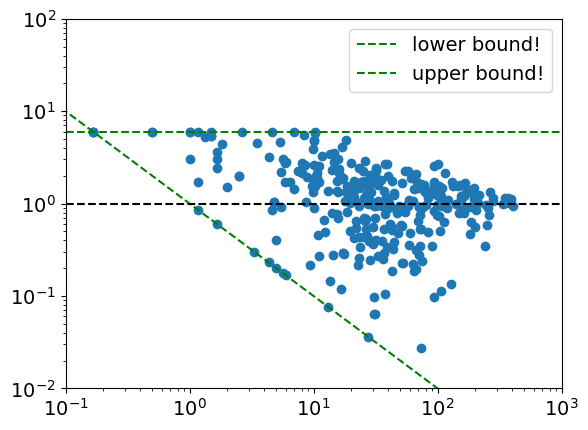

In [13]:
sorted_c_metr = plt_cmetr.sort_values(by='call_rate (6of6)').replace(0, np.NaN).dropna()
ref_dc_metr = plt_dcmetr.loc[sorted_c_metr.index]
error_ratio_df = pd.DataFrame(ref_dc_metr.values / sorted_c_metr.values, index=ref_dc_metr.index, columns=['error (1of6)'])

non_zero_c_metr_min = sorted_c_metr.min().min()
non_zero_c_metr_max = sorted_c_metr.max().max()
non_zero_dc_metr_min = 1/time_on

lower_bound_c_values = np.logspace(-3, 3, 3)
plt.scatter(sorted_c_metr['call_rate (6of6)'], (error_ratio_df['error (1of6)']))
plt.plot(lower_bound_c_values, non_zero_dc_metr_min/lower_bound_c_values, 
         linestyle='dashed', color='g', label='lower bound!')
plt.axhline(y=1/listening_ratio, linestyle='dashed', color='g', label='upper bound!')
plt.axhline(y=1, linestyle='dashed', color='k')
plt.ylim(1e-2, 1e2)
plt.xlim(1e-1, 1e3)
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()

In [14]:
def plot_indiv_dc_control_comp_error_over_cycle_log_scale(plt_dcmetr, plt_cmetr, data_params):
    cont_metric_col_name = plt_cmetr.columns[0]
    sorted_c_metr = plt_cmetr.sort_values(by=cont_metric_col_name).replace(0, np.NaN).dropna()
    ref_dc_metr = plt_dcmetr.loc[sorted_c_metr.index]
    error_ratio_df = pd.DataFrame(ref_dc_metr.values / sorted_c_metr.values, index=ref_dc_metr.index, columns=[f'error ({dc_col})'])
    dc_tag_split = re.findall(r"\d+", ref_dc_metr.columns[0])
    cycle_length = int(dc_tag_split[-1])
    time_on = int(dc_tag_split[0])
    listening_ratio = time_on/cycle_length

    error_ratio_df.index = pd.DatetimeIndex(error_ratio_df.index)
    error_ratio_table = pd.pivot_table(error_ratio_df, index=(error_ratio_df.index.time), 
                        columns=error_ratio_df.index.date, 
                        values=error_ratio_df.columns[0])

    dctag1 = re.search(r"\d+of\d+", ref_dc_metr.columns[0])[0]
    metrictag1 = (sorted_c_metr.columns[0]).split()[0]
    sorted_c_metr.index = pd.DatetimeIndex(sorted_c_metr.index)
    paired_col_c_metr = sorted_c_metr[(~sorted_c_metr.isna()).values]
    c_metr = pd.pivot_table(paired_col_c_metr, index=(paired_col_c_metr.index.time), 
                    columns=paired_col_c_metr.index.date, 
                    values=paired_col_c_metr.columns[0])
    bound_c_values = np.logspace(-3, 3, 3)
    if data_params['metric_tag']=='activity_index':
        lower_bound = (100/(60/5))*(1/time_on)
        plt.plot(bound_c_values, lower_bound/bound_c_values, 
                 linestyle='dashed', color='g', label='low: $on time^{-1}$/c')
    elif data_params['metric_tag']=='call_rate':
        lower_bound = (1/time_on)
        plt.plot(bound_c_values, lower_bound/bound_c_values, 
                 linestyle='dashed', color='g', label='low: $on time^{-1}$/c')
        
    if data_params['metric_tag']=='bout_time_percentage':
        plt.plot(bound_c_values, 100/bound_c_values, 
                 linestyle='dashed', color='g', label='100% line')
    elif data_params['metric_tag']=='activity_index':
        plt.plot(bound_c_values, 100/bound_c_values, 
                 linestyle='dashed', color='g', label='100% line')

    plt.title(f'{dctag1} and continuous scheme')
    colors = np.tile(np.arange(0, c_metr.shape[0]),(c_metr.shape[1],1)).T
    labels = pd.to_datetime(c_metr.index, format='%H:%M:%S').strftime('%H:%M')
    sc = plt.scatter(c_metr, error_ratio_table, c=colors, cmap='YlOrRd', edgecolors='k', s=80, alpha=1)
    cbar = plt.colorbar(sc, ticks=[0, (colors.shape[0]-1)//2, colors.shape[0]-1])
    cbar.ax.set_yticklabels([labels[0], labels[len(labels)//2], labels[-1]])
    plt.axhline(y=listening_ratio**-1, linestyle='dashed', color='g', label='upp: $ratio^{-1}$')
    plt.axhline(y=1, linestyle='dashed', color='k')
    if (data_params['metric_tag'] == 'call_rate'):
        plt.xlim(1e-3, 1e3)
        plt.ylim(1e-4, 1e1)
    else:
        plt.xlim(1e-2, 2e2)
        plt.ylim(1e-3, 1e1)
    plt.yscale('log')
    plt.xscale('log')
    plt.grid(which='both')
    plt.ylabel(f'Error Ratio {dctag1}')
    plt.xlabel(f'{metrictag1}')
    plt.legend(loc=3)

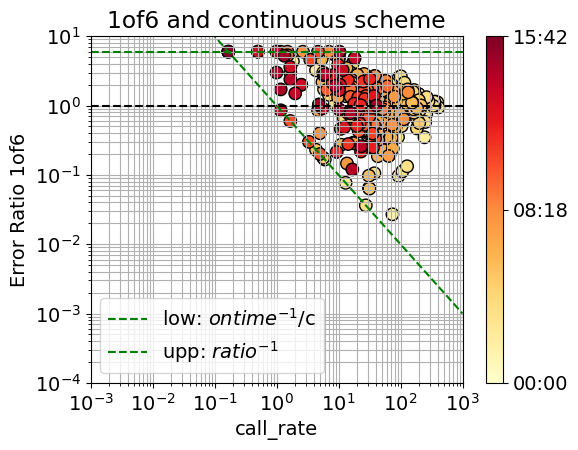

In [15]:
plt.figure(figsize=(6, 4.5))
plt.rcParams.update({'font.size':14})
prev_cycle = 0
dc_col = '1of6'
dc_metric_col_name = f'{data_params["metric_tag"]} ({dc_col})'
cycle_length = int(dc_col.split('of')[-1])
cont_tag = f'{cycle_length}of{cycle_length}'

cont_metric_col_name = f'{data_params["metric_tag"]} ({cont_tag})'
callrate_cont_column = pd.DataFrame(callrate_arr.loc[:,cont_metric_col_name].dropna())
metric_for_scheme = pd.DataFrame(activity_arr.loc[:,dc_metric_col_name].dropna())
metric_for_scheme_for_comparison = comp.get_associated_metric_for_cont_column(metric_for_scheme, callrate_cont_column)
plt_dcmetr, plt_cmetr = comp.select_dates_from_metrics(metric_for_scheme_for_comparison, callrate_cont_column, data_params)
plot_indiv_dc_control_comp_error_over_cycle_log_scale(plt_dcmetr, plt_cmetr, data_params)

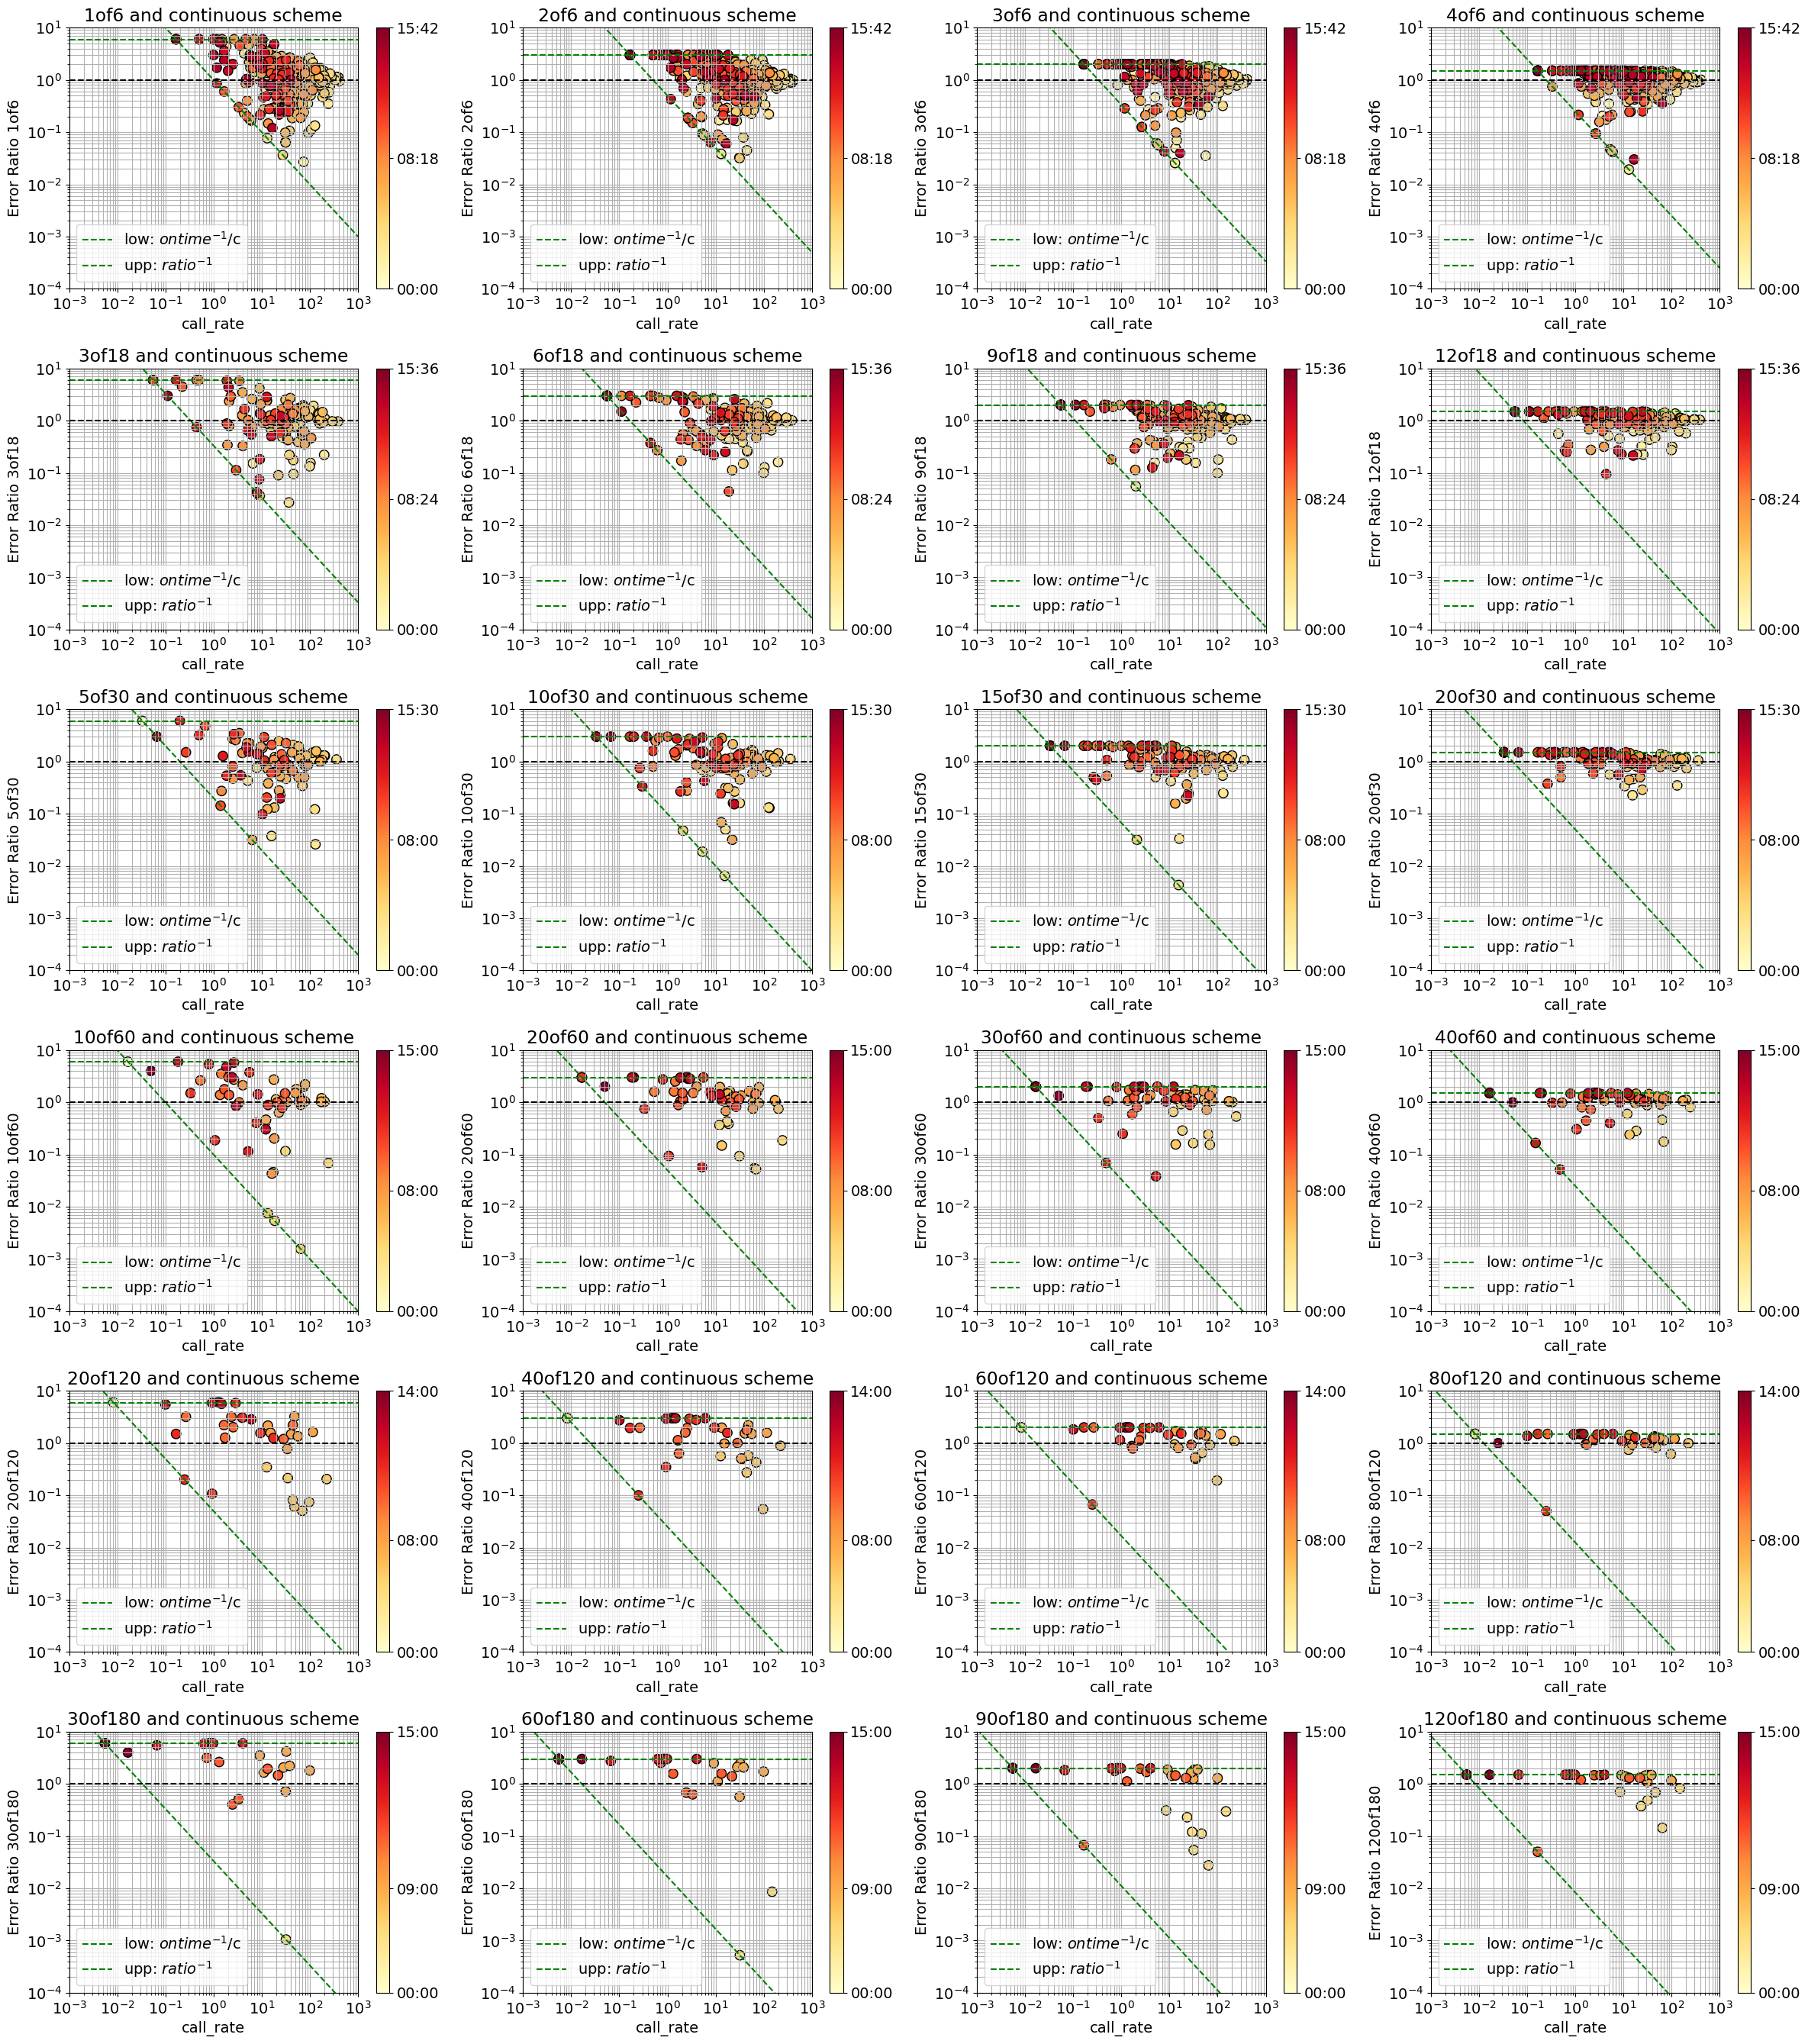

In [16]:
plt.figure(figsize=(6*len(data_params['percent_ons']), 4.5*len(data_params['cycle_lengths'])))
plt.rcParams.update({'font.size':14})
prev_cycle = 0
for i, dc_col in enumerate(data_params["dc_tags"][1:]):
    plt.subplot(len(data_params['cycle_lengths']), len(data_params['percent_ons']), i+1)
    metric_col_name = f'{data_params["metric_tag"]} ({dc_col})'
    cycle_length = int(dc_col.split('of')[-1])
    cont_tag = f'{cycle_length}of{cycle_length}'
    cont_metric_col_name = f'{data_params["metric_tag"]} ({cont_tag})'
    callrate_cont_column = pd.DataFrame(callrate_arr.loc[:,cont_metric_col_name].dropna())
    metric_for_scheme = pd.DataFrame(activity_arr.loc[:,metric_col_name].dropna())
    metric_for_scheme_for_comparison = comp.get_associated_metric_for_cont_column(metric_for_scheme, callrate_cont_column)
    plt_dcmetr, plt_cmetr = comp.select_dates_from_metrics(metric_for_scheme_for_comparison, callrate_cont_column, data_params)
    plot_indiv_dc_control_comp_error_over_cycle_log_scale(plt_dcmetr, plt_cmetr, data_params)

plt.tight_layout()
plt.show()